In [119]:
#! /usr/bin/env python3
import itertools
import collections
import os
import pickle
import string
from random import shuffle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import spacy
import nltk
from nltk.tokenize import word_tokenize, wordpunct_tokenize

import utils
from utils import FeedForwardNet

import IPython.display

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# load the trained embeddings 
path = './data/glove.6B.50d.txt'
embeddings = {}
with open(path) as f:
    for line in f.readlines():
        tokens = line.strip().split(' ')
        word = tokens[0]
        vec = np.asarray(tokens[1:], dtype=float)
        embeddings[word] = vec
        
print(embeddings[','])
print(embeddings[','].shape)

[ 0.013441  0.23682  -0.16899   0.40951   0.63812   0.47709  -0.42852
 -0.55641  -0.364    -0.23938   0.13001  -0.063734 -0.39575  -0.48162
  0.23291   0.090201 -0.13324   0.078639 -0.41634  -0.15428   0.10068
  0.48891   0.31226  -0.1252   -0.037512 -1.5179    0.12612  -0.02442
 -0.042961 -0.28351   3.5416   -0.11956  -0.014533 -0.1499    0.21864
 -0.33412  -0.13872   0.31806   0.70358   0.44858  -0.080262  0.63003
  0.32111  -0.46765   0.22786   0.36034  -0.37818  -0.56657   0.044691
  0.30392 ]
(50,)


In [103]:
embedding_words, embedding_vecs = zip(*embeddings.items())

In [104]:
display(embedding_words)
display(embedding_vecs)

('veronicas',
 'politely',
 'cowhide',
 "d'aumale",
 'mid-1967',
 'wrinkled',
 'squeaker',
 '1582',
 'equitable',
 'glamorizing',
 'gunpla',
 'giannelli',
 'alshammar',
 '49.55',
 'amess',
 'decidido',
 'purell',
 'great-great',
 'elba',
 'fusses',
 'woodmont',
 'masterpieces',
 'archæologia',
 'equator',
 'cales',
 'fazal',
 'gabo',
 '108.37',
 'bivona',
 'ninna',
 'vdm',
 'nadesico',
 'winget',
 'hydrocyanic',
 'mzembi',
 '27.40',
 '97.02',
 'ponsford',
 'mrap',
 'deslauriers',
 'sumptuous',
 'shadwell',
 'amyema',
 'delvaux',
 'tional',
 'haeundae',
 'nissanka',
 'long-cherished',
 'them',
 'devante',
 'tripods',
 'b.a',
 'f-4j',
 'ent',
 'aelfric',
 'raceme',
 'canyonres',
 'taipa',
 'p-type',
 'buth',
 '8-over',
 '53-year-old',
 'disney-owned',
 'gruson',
 'buffets',
 'juergensmeyer',
 'girocredit',
 'whitelaw',
 'mitaka',
 'reverently',
 'depletion',
 'hansraj',
 'bozos',
 'romanic',
 'maclellan',
 'tattenhall',
 'aiyaz',
 'videha',
 'forsake',
 'aere',
 'edelman',
 'financers',


(array([ 0.04777  , -0.23894  , -0.21537  ,  0.047142 , -0.14731  ,
         0.22347  , -0.33976  ,  0.53082  ,  0.53274  ,  0.11192  ,
         0.70615  ,  0.45076  ,  0.49242  ,  1.0201   , -0.26565  ,
        -0.30163  , -0.13093  , -0.92826  ,  0.30168  ,  0.54159  ,
        -0.47796  , -0.076268 , -0.12591  , -0.31807  ,  0.33083  ,
         1.2071   , -0.5106   , -0.38544  , -0.33592  , -0.3597   ,
        -0.53691  ,  0.22208  ,  0.73778  ,  0.3488   , -0.21643  ,
         0.40781  ,  0.26826  , -1.044    , -0.81218  , -0.86924  ,
        -0.20878  , -1.207    ,  0.0048683, -0.32933  ,  0.42253  ,
        -0.31338  ,  0.36525  , -0.1685   , -0.60301  , -0.62064  ]),
 array([-0.088363, -0.86798 , -0.071246, -0.99309 ,  1.0406  , -0.67187 ,
        -0.3672  ,  0.93936 , -0.81159 , -0.14677 , -0.16833 ,  0.40164 ,
         0.36102 , -0.25038 ,  0.52517 ,  0.27179 , -1.0291  , -0.52153 ,
         1.0258  , -1.2331  ,  0.10959 ,  0.87093 ,  0.40496 ,  0.042136,
         1.2934  , -1.

In [115]:
with open('./data/bigram_ngrams', 'rb') as f:
    bigram_counter = pickle.load(f)

In [85]:
# prepare real data
def ngram_to_embedding(ngram):
    return np.hstack([embeddings[token.lower()] for token in ngram])

def safe_convert_to_embedding(bigram_counters, n_needed_bigram=np.inf):
    to_return = []
    not_trained_bigrams = []
    for bigram, count in bigram_counters.items():
        try:
            to_return.append(ngram_to_embedding(bigram))
            if len(to_return) == n_needed_bigram:
                break
        except KeyError:
            not_trained_bigrams.append((bigram, count))
            
    return to_return, not_trained_bigrams        

In [86]:
most_common_bigrams_ngram = dict(bigram_counter_ngram.most_common(55000))
x_true, not_trained_bigrams = safe_convert_to_embedding(most_common_bigrams_ngram, 50000)
display(x_true)
display(not_trained_bigrams)

[array([ 0.82237 ,  1.4736  ,  0.559   , -0.090876, -0.94606 , -0.663   ,
        -0.98675 ,  0.33529 ,  0.30442 , -1.1748  , -0.2169  , -1.1183  ,
         0.92651 , -0.89967 , -0.76239 ,  0.53982 ,  0.99491 ,  0.014052,
        -0.60326 , -0.21344 , -1.5779  , -0.295   ,  0.33557 ,  0.14183 ,
         0.46696 , -0.92669 , -1.3253  ,  0.99845 , -0.14457 , -0.36956 ,
         1.9932  , -0.69049 , -0.47334 , -0.23069 ,  0.71979 ,  0.074148,
        -1.693   , -0.20081 , -0.077967,  0.05116 , -0.55452 ,  0.65376 ,
         0.70734 , -0.85363 , -0.32085 , -0.64243 ,  1.0425  , -0.94434 ,
        -0.59999 , -1.6693  ,  0.26818 ,  0.14346 , -0.27877 ,  0.016257,
         0.11384 ,  0.69923 , -0.51332 , -0.47368 , -0.33075 , -0.13834 ,
         0.2702  ,  0.30938 , -0.45012 , -0.4127  , -0.09932 ,  0.038085,
         0.029749,  0.10076 , -0.25058 , -0.51818 ,  0.34558 ,  0.44922 ,
         0.48791 , -0.080866, -0.10121 , -1.3777  , -0.10866 , -0.23201 ,
         0.012839, -0.46508 ,  3.8463 

[(('over', 'medium-high'), 1869),
 (('equation(s', 'can'), 740),
 (('tom', 'jarriel'), 1631),
 (('extra-virgin', 'olive'), 725),
 (('i-', 'i'), 1084),
 (('the', 'nation/science'), 838),
 (('u.s.c', 'section'), 1100),
 (('i', "don't"), 673),
 (("c'm", 'on'), 1694),
 (('line', 'equation(s'), 740),
 (('noon-1:00', 'pm'), 1083),
 (('am-12:00', 'noon'), 651),
 (('daniel', 'zwerdling'), 1162),
 (('pre-formatted', 'table'), 1622),
 (('medium-high', 'heat'), 1913),
 (('preservice', 'teachers'), 1265),
 (('john', 'donvan'), 715)]

In [101]:
x_true = np.asarray(x_true)
print(x_true.shape)
display(x_true)

(50000, 100)


array([[ 0.82237 ,  1.4736  ,  0.559   , ..., -0.6321  , -0.25028 ,
        -0.38097 ],
       [ 0.418   ,  0.24968 , -0.41242 , ...,  1.4794  ,  0.69301 ,  1.121   ],
       [-0.95849 ,  0.17321 ,  0.25165 , ...,  0.68464 , -0.43253 ,
         0.75606 ],
       ..., 
       [-0.19461 , -0.051277,  0.26445 , ...,  0.48463 ,  0.056849,
         0.47113 ],
       [ 0.6185  ,  0.64254 , -0.46552 , ...,  0.080906,  0.052606,
         0.21056 ],
       [ 0.04905 ,  0.49645 , -0.13445 , ..., -0.22562 , -0.093918,
        -0.80375 ]])

Construct the neural network
-------------

In [24]:
embedding_size = 50
n_gram = 2
vis_size = n_gram * embedding_size        # the size of the input embedding (from glove)
latent_size = 50
hidden_size = 500
learning_rate = .05

Z = tf.placeholder('float', [None, latent_size])
X = tf.placeholder('float', [None, vis_size])
Y = tf.placeholder('float', [None, 1])

In [152]:
# build a discrimnator 
layer_sizes = [vis_size, hidden_size, 1]
discriminator_net = FeedForwardNet(layer_sizes, [tf.nn.tanh, None])
true_data_predict = discriminator_net.out(X)
discriminator_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(true_data_predict, Y))
train_discriminator = (tf.train.GradientDescentOptimizer(learning_rate)
                       .minimize(discriminator_cost, var_list=discriminator_net.all_parameters))

In [153]:
# build a generator
layer_sizes = [latent_size, hidden_size, vis_size]
generator_net = FeedForwardNet(layer_sizes, [tf.nn.tanh, None])
generator_out = generator_net.out(Z)

# train generator to maximize classification error
generated_data_predict = discriminator_net.out(generator_out)
# notice the negative sign, since we are *maximize* the cost, 
generator_cost = tf.reduce_mean(-tf.nn.sigmoid_cross_entropy_with_logits(generated_data_predict, Y))
train_generator = (tf.train.GradientDescentOptimizer(learning_rate)
                   .minimize(generator_cost, var_list=generator_net.all_parameters))

![GAN training algorithm](./GAN.png)

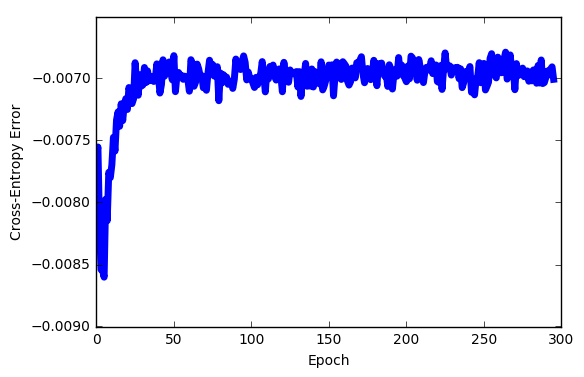

In [162]:
# trainng parameters
n_samples = len(x_true)
n_epochs = 300 

# prepare mini-batches
batch_size = 500 
n_batches = n_samples // batch_size
mini_batch_slices = [
    slice(i * batch_size, (i+1) * (batch_size))
    for i in range(n_batches)
]

# the labels for real samples and generated samples.
Y_real_data = np.ones([batch_size, 1])
Y_generated = np.zeros([batch_size, 1])
y_train = np.vstack([Y_real_data, Y_generated])

# store the training results
generator_weights = None
generator_bias = None

# start training
loss_tracker = []
with tf.Session() as session:
    tf.initialize_all_variables().run()

    for epoch in range(n_epochs):
        discriminator_loss = 0.
        generator_loss = 0.
        # TODO should I shuffle X in every epoch ?
        for i in range(n_batches):
            # 1. train the discriminator
            
            # sample from generator
            prior_samples = np.random.normal(size=(batch_size, latent_size))
            generated_samples = session.run(generator_out, feed_dict={Z: prior_samples})

            x_train = np.vstack([x_true[mini_batch_slices[i]], generated_samples])
            x_train, y_train = utils.shuffle_in_unison_inplace(x_train, y_train)
            _, l = session.run([train_discriminator, discriminator_cost],
                                feed_dict={X: x_train, Y: y_train})
            
            # 2. train the generator
            prior_samples = np.random.normal(size=(batch_size, latent_size))
            _, l_g = session.run([train_generator, generator_cost], 
                                 feed_dict={Z: prior_samples, Y: Y_generated})
            
        discriminator_loss += l
        generator_loss += l_g        
        
        loss_tracker.append(generator_loss / n_batches)
        
        if epoch % 5 == 0:
            # show the optimization progress
            IPython.display.clear_output(wait=True)
            plt.plot(loss_tracker, linewidth=5)
            plt.xlim(0, n_epochs)
            plt.xlabel("Epoch")
            plt.ylabel("Cross-Entropy Error")
            plt.show()

In [100]:
IPython.display.display(loss_tracker)

[0.0069219124317169188,
 0.0069317364692687991,
 0.0069310641288757328,
 0.0069326049089431761,
 0.0069290357828140255,
 0.006929934024810791,
 0.0069317239522933959,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.0069314610958099362,
 0.00693146109580

In [109]:
def convert_embedding_to_word(embedding):
    idx = np.argmin(np.sum((embedding_vecs - embedding) ** 2, axis=1))
    return embedding_words[idx]

def convert_embedding_to_bigarm(embedding):
    embedding_word_1 = embedding[:embedding_size]
    embedding_word_2 = embedding[embedding_size:]
    return (convert_embedding_to_word(embedding_word_1),
            convert_embedding_to_word(embedding_word_2))

In [168]:
for idx in range(20):
    print(convert_embedding_to_bigarm(generated_samples[idx]))

('late', 'best')
('mission', 'between')
('governor', 'more')
('constitution', 'students')
('am', 'overseas')
('influential', 'albanian')
('during', 'into')
('business', 'driving')
('car', 'sound')
('a', 'rules')
('flew', 'cases')
('environment', 'centuries')
('majorities', 'slang')
('convention', 'responsibility')
('north', 'people')
('down', 'their')
('an', 'million')
('development', 'violence')
('new', 'nerve')
('machine', 'him')
